<a href="https://colab.research.google.com/github/chambai/Deep_Learning_Course/blob/main/Week%203%20Deep%20RL%201/CartPoleQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning with the CartPole environment
The code below is an implementation of Q-Learning, adapted from https://medium.com/@flomay/using-q-learning-to-solve-the-cartpole-balancing-problem-c0a7f47d3f9d

In [ ]:
# load libraries
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


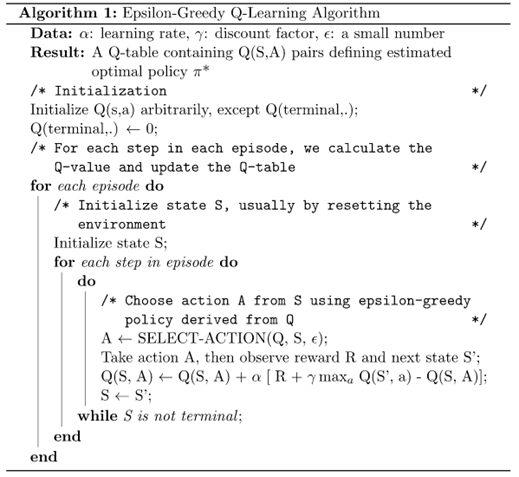

In [ ]:
"""
Base code taken from: 
https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py
"""

class CartPoleQAgent():
    def __init__(self, buckets=(3, 3, 6, 6), 
                 num_episodes=500, min_lr=0.1, 
                 min_epsilon=0.1, discount=1.0, decay=25):
        self.buckets = buckets            # buckets to discretize continuous values
        self.num_episodes = num_episodes  # number of episodes to run
        self.min_lr = min_lr              # minimum learning rate in the Q-Learning algorithm
        self.min_epsilon = min_epsilon    # minimum epsilon (minimum amount of randomness in action selection)
        self.discount = discount          # how far into the future the algorithm looks
        self.decay = decay                # the amount epsilon is reduced by as the learning progresses

        self.env = gym.make('CartPole-v0')  # load the environment
        
        # This is the action-value function being initialized to 0's
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))  # initialise the Q-Table that stores the states and actions
        print(self.Q_table.shape) # (3,3,6,6,2)

        # set the limit the bounds of the observations so they can be used in the discretization
        # [position, velocity, angle, angular velocity]
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        
        # initialise steps to the number of episodes
        self.steps = np.zeros(self.num_episodes)
        
        
    def discretize_state(self, obs):
        """
        Takes an observation of the environment and aliases it.
        By doing this, very similar observations can be treated
        as the same and it reduces the state space so that the 
        Q-table can be smaller and more easily filled.
        
        Input:
        obs (tuple): Tuple containing 4 floats describing the current
                     state of the environment.
        
        Output:
        discretized (tuple): Tuple containing 4 non-negative integers smaller 
                             than n where n is the number in the same position
                             in the buckets list.
        """
        discretized = list()
        for i in range(len(obs)):
            scaling = ((obs[i] + abs(self.lower_bounds[i])) 
                       / (self.upper_bounds[i] - self.lower_bounds[i]))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    def choose_action(self, state):
        """
        Implementation of e-greedy algorithm. Returns an action (0 or 1).
        
        Input:
        state (tuple): Tuple containing 4 non-negative integers within
                       the range of the buckets.
        
        Output:
        (int) Returns either 0 or 1
        """
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() # exploration
        else:
            return np.argmax(self.Q_table[state]) # exploitation


    def update_q(self, state, action, reward, new_state):
        """
        Updates Q-table using the rule as described by Sutton and Barto in
        Reinforcement Learning.
        """
        self.Q_table[state][action] += (self.learning_rate * 
                                        (reward 
                                         + self.discount * np.max(self.Q_table[new_state]) 
                                         - self.Q_table[state][action]))

    def get_epsilon(self, t):
        """Gets value for epsilon. It declines as we advance in episodes."""
        # Ensures that there's almost at least a min_epsilon chance of randomly exploring
        # print('10: ' + str(max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / 10)))))
        # print('90: ' + str(max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / 90)))))
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    def get_learning_rate(self, t):
        """Gets value for learning rate. It declines as we advance in episodes."""
        # Learning rate also declines as we add more episodes
        # print('10: ' + str(max(self.min_lr, min(1., 1. - math.log10((t + 1) / 10)))))
        # print('90: ' + str(max(self.min_lr, min(1., 1. - math.log10((t + 1) / 90)))))
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def train(self):
        """
        Trains agent making it go through the environment and choose actions
        through an e-greedy policy and updating values for its Q-table. The 
        agent is trained by default for 500 episodes with a declining 
        learning rate and epsilon values that with the default values,
        reach the minimum after 198 episodes.
        """
        # Looping for each episode
        for e in range(self.num_episodes):
            # Initializes the state
            current_state = self.discretize_state(self.env.reset())

            self.learning_rate = self.get_learning_rate(e)
            self.epsilon = self.get_epsilon(e)
            done = False
            
            # Looping for each step
            while not done:
                self.steps[e] += 1
                # Choose A from S
                action = self.choose_action(current_state)
                # Take action
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                # Update Q(S,A)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                
                # We break out of the loop when done is False which is
                # a terminal state.
        print('Finished training!')
    
    def plot_learning(self):
        """
        Plots the number of steps at each episode and prints the
        amount of times that an episode was successfully completed.
        """
        sns.lineplot(range(len(self.steps)),self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(self.num_episodes):
            if self.steps[i] == 200:
                t+=1
        print(t, "episodes were successfully completed.")
        

    def run(self):
        """Runs an episode while displaying the cartpole environment."""
        self.env = gym.wrappers.Monitor(self.env,'cartpole')
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t

In [ ]:
# as the CartPole environment has continuous values for the observations
# we need to discretize these otherwise it will take too long to train
# this is what the buckets are for.  It specifies the number of groups each observation is be discreteized into
# in general, you would want fewer buckets to keep the state space as small as possible.
# However, discretizing the state space too much might prevent training as important information may be lost

# this Q-Learning implementation reduces the learning rate as the episodes increase
agent = CartPoleQAgent(buckets=(3, 3, 6, 6), num_episodes=1000, min_lr=0.1, min_epsilon=0.1, discount=1.0, decay=25)
agent.train()
agent.plot_learning()

**Set discount to 0.5.  What happens and why does this happen?**

**What does changing the bucket sizes do and why?** 

**What does changing the learning rate (alpha) do?** 

**Change the decay rate to 10. What does this do and why?**  

**Change the decay rate to 90. What does this do?** 

